## 수치 미분을 이용한 심층 신경망 학습  
### Back Propagation을 이용해서 Gradient Descent을 실제로 구현해 보겠습니다.  

역전파에서 중요한 것은 체인룰과 다이나믹 프로그램입니다. 
다이나믹 프로그램 : 나중에 쓸 계산값을 미리 저장해 놓고 필요할 때 불러다 쓰는 것입니다.
체인 룰 : 미분을 계산할 때 한번에 미분을 계산하지 않고 그 중간중간 미분들을 이용해서 각 미분값을 곱해서 미분값을 구하는 방식입니다.  

두가지의 콜라보로 인해서 역전파 학습이 가능하다. 그러기 위해서는 다이나믹 프로그램을 위한 메모리를 잡아야 하기때문에 클래스를 만들어서 필요한 메모리를 저장할 수 있게 합니다.

In [12]:
import time
import numpy as np

## 유틸리티 함수

In [13]:
def _t(x):
    return np.transpose(x)

def _m(A, B):
    return np.matmul(A, B)

## Sigmoid 구현  
sigmoid를 call 할때마다 필요한 값들을 미리 저장해 놓고 bp를 할때 grad같은경우는 다음레이어와 입력 레이어 사이의 미분을 구합니다.

In [14]:
class Sigmoid:
    def __init__(self): #마지막 출력을 미리 1로 초기화해서 저장해 놓습니다.
        self.last_o=1

    def __call__(self, x):
        self.last_o=1/(1.0+np.exp(-x)) #sigmoid 함수의 정의
        return self.last_o
    def grad(self): #sigmoid(x)(1-sigmoid(x))
        return self.last_o*(1-self.last_o)
    #마지막에 저장된것을 받고 현재 gradient를 곱해줍니다.

## Mean Squared Error 구현  
한번 콜할때 필요한걸 저장하고 grad을 계산하면 다음레이어로부터 입력으로까지의 미분을 구할 수 있습니다.

In [15]:
class MeanSquaredError:
    def __init__(self):
        #gradient
        self.dh=1 #gradient를 저장할 수 있는 공간을 만듭니다. 
        self.last_diff=1
    def __call__(self, h, y): # 1/2 * mean(h-y)^2->입력이 미분되면 제곱이 내려와 상수가 상쇄됩니다.
        self.last_diff=h-y
        return 1/2*np.mean(np.square(h-y))

    def grad(self): #h-y가 되겠죠.
        return self.last_diff

## 뉴런 구현  
뉴런은 Fully Connected Layer 입니다.  
뉴런도 마찬가지로 call을 할때 필요한 것들을 미리 저장하고 grad를 이용하면 다음 레이어의 출력 입력 사이의 미분을 구하는데 grad를 이용합니다.  

grad_b : 지금까지의 미분을 다곱해서 입력으로 받아서 b를 어떻게 업데이트 할것인지, loss function을 b로 미분한 결과를 리턴해줍니다.

In [20]:
class Neuron:
    def __init__(self, W, b, a_obj): #모델의 파라미터를 저장합니다.
        # Model parameters
        self.W=W
        self.b=b
        self.a=a_obj() #sigmoid class를 받아줘야 합니다.
        
        #gradient
        self.dW=np.zeros_like(self.W)
        self.dW=np.zeros_like(self.b)
        self.dh=np.zeros_like(_t(self.W))
        
        self.last_x=np.zeros((self.W.shape[0])) #마지막 x를 저장해줍니다.W를 미분했을때 이전 입력이 있어야 미분할 수 있으니 마지막 x를 미리 저장해 둡니다. w gradient를 위해서 입니다.
        self.last_h=np.zeros((self.W.shape[1])) #마지막으로 나가는 출력도 저장을 해 줍니다.
    def __call__(self, x):#콜을 했을 때 마지막으로 들어온 입력을 기억해 줍니다.
        self.last_x=x
        self.last_h=_m(_t(self.W),x)+self.b
        return self.a(self.last_h)

    def grad(self): #hn-1
        return self.W * self.a.grad() #W만 살아남고 activation을 곱해줍니다.
                    
    def grad_W(self, dh): #weight로 미분을 할 경우. x만 남습니다. dy/dw=x
        grad=np.ones_like(self.W)
        grad_a=self.a.grad()
        for j in range(grad.shape[1]):#1은 출력쪽 디멘션
            grad[:,j]=dh[j] * grad_a[j]*self.last_x
            # y=w^Tx+b
        return grad #w로 미분한 gradient가 출력됩니다.
    def grad_b(self, dh): #bias입니다. y=Wx+b에서 b로 미분하면 1이 되죠.
        return dh * self.a.grad() *1 #b로 미분하면 1이기때문에 마지막에 1을 곱합니다. 없어도 됩니다.

## 심층신경망 구현



In [21]:
class DNN:
    def __init__(self, hidden_depth, num_neuron, input, output, activation=Sigmoid):
        def init_var(i, o):
            return np.random.normal(0.0, 0.01, (i, o)), np.zeros((o,))

        self.sequence = list()
        # First hidden layer
        W, b = init_var(input, num_neuron)
        self.sequence.append(Neuron(W, b, activation))

        # Hidden Layers
        for index in range(hidden_depth):
            W, b = init_var(num_neuron, num_neuron)
            self.sequence.append(Neuron(W, b, activation))

        # Output Layer
        W, b = init_var(num_neuron, output)
        self.sequence.append(Neuron(W, b, activation))

    def __call__(self, x):
        for layer in self.sequence:
            x = layer(x)
        return x

    def calc_gradient(self, loss_obj):#전체 미분을 통합해 보겠습니다.
        loss_obj.dh=loss_obj.grad() #dh는 전부 gradient 입니다.
        self.sequence.append(loss_obj)
        #back-propagation loop를 구현해 보겠습니다.
        for i in range(len(self.sequence)-1,0,-1):
            l1=self.sequence[i]
            l0=self.sequence[i-1]
            
            l0.dh=_m(l0.grad(),l1.dh)
            l0.dw=l0.grad_W(l1.dh) 
            l0.db=l0.grad_b(l1.dh) #loss function을 b로도 미분해서 저장해 줍니다.
        self.sequence.remove(loss_obj)

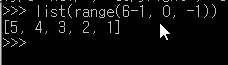
list(range(6-1,0,-1))  

5 4 3 2 1 이 출력됩니다.

## 경사하강 학습법

In [22]:
def gradient_descent(network, x, y, loss_obj, alpha=0.01):
    loss = loss_obj(network(x), y)  # Forward inference
    network.calc_gradient(loss_obj)  # Back-propagation
    for layer in network.sequence:
        layer.W += -alpha * layer.dW
        layer.b += -alpha * layer.db
    return loss

## 동작 테스트 

In [23]:
x = np.random.normal(0.0, 1.0, (10,))
y = np.random.normal(0.0, 1.0, (2,))

t = time.time()
dnn = DNN(hidden_depth=5, num_neuron=32, input=10, output=2, activation=Sigmoid)
loss_obj = MeanSquaredError()
for epoch in range(100):
    loss = gradient_descent(dnn, x, y, loss_obj, alpha=0.01)
    print('Epoch {}: Test loss {}'.format(epoch, loss))
print('{} seconds elapsed.'.format(time.time() - t))

Epoch 0: Test loss 0.1114121335078407
Epoch 1: Test loss 0.111272899385605
Epoch 2: Test loss 0.11113384158676853
Epoch 3: Test loss 0.1109949601948446
Epoch 4: Test loss 0.11085625529147256
Epoch 5: Test loss 0.11071772695642289
Epoch 6: Test loss 0.11057937526760278
Epoch 7: Test loss 0.1104412003010612
Epoch 8: Test loss 0.11030320213099433
Epoch 9: Test loss 0.11016538082975127
Epoch 10: Test loss 0.11002773646783898
Epoch 11: Test loss 0.10989026911392807
Epoch 12: Test loss 0.10975297883485816
Epoch 13: Test loss 0.1096158656956435
Epoch 14: Test loss 0.10947892975947852
Epoch 15: Test loss 0.10934217108774334
Epoch 16: Test loss 0.10920558974000932
Epoch 17: Test loss 0.10906918577404512
Epoch 18: Test loss 0.10893295924582169
Epoch 19: Test loss 0.10879691020951857
Epoch 20: Test loss 0.10866103871752947
Epoch 21: Test loss 0.10852534482046779
Epoch 22: Test loss 0.10838982856717264
Epoch 23: Test loss 0.10825449000471472
Epoch 24: Test loss 0.10811932917840184
Epoch 25: Test l

1. 경사하강 학습법에서 'Forward inference'가 먼저 한번 계산이 됩니다.
2. 한번씩 콜이 일어날때 last_diff이 불려지고 저장이 됩니다.
3. 뉴런에서도 콜이 되면서 last_x last_h 가 저장이 됩니다.
4. sigmoid도 한번씩 콜이 되면서 last_o가 저장이 됩니다.
5. 이제 gradient를 콜 해주기만 하면 전부 마지막에 연산됐던걸 활용해서 gradient를 뱉어주게 됩니다. 굉장히 편리하게 gradient를 계산할 수 있죠.

## numerical에 비해서 bp는 엄청 빠른 속도로 동작됨을 볼 수 있습니다.
## neuron을 64,128로 변경해보고 hidden_depth도 10,20으로 증가시켜 보면서 DNN을 구현해 보면 속도가 안정적으로 조금씩 증가하는것을 확인할 수 있습니다. 